In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('../data/Tweets.csv')

In [3]:
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [5]:
df_1 = df.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1)

In [6]:
df_1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


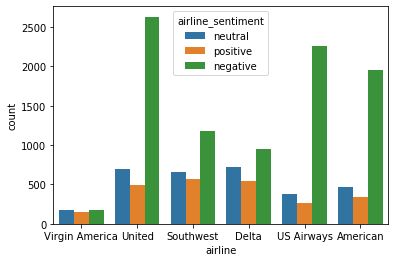

In [7]:
sns.countplot(df_1['airline'], hue=df_1['airline_sentiment'])

In [8]:
df_1['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [9]:
df_1['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [66]:
df_1['tweet_location'].value_counts()

Boston, MA                157
New York, NY              156
Washington, DC            150
New York                  127
USA                       126
                         ... 
ÜT: 48.837756,2.320214      1
Powell, TN                  1
Guatemala                   1
Weston, CT USA              1
with my brothers            1
Name: tweet_location, Length: 3081, dtype: int64

In [75]:
df_1['user_timezone'].value_counts().head(50)

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Hawaii                          104
Amsterdam                        74
America/Chicago                  37
Indiana (East)                   26
America/New_York                 26
Paris                            25
Brasilia                         23
Abu Dhabi                        23
Dublin                           17
Greenland                        17
Tehran                           17
Santiago                         17
Athens                           16
America/Los_Angeles              15
Mid-Atlantic                     15
New Delhi                        15
Casablanca                       15
Buenos Aires                

In [81]:
df_1['tweet_location'][df_1['user_timezone'].isnull()].value_counts()

New York                 47
San Francisco, CA        29
Boston, MA               26
USA                      25
San Diego                24
                         ..
Seattle, WA               1
Charlestown, MA           1
Roseville, California     1
Tipperary, Ireland        1
Dallas, TX                1
Name: tweet_location, Length: 817, dtype: int64

In [73]:
us_time = {'AKST': ['AK', 'ALASKA'], 
           'CST': ['AL', 'AR', 'IL', 'IA', 'KS', 'KY', 'LA', 'MN', 'MI', 'MO', 
                 'NE', 'ND', 'OK', 'SD', 'TN', 'TX', 'WI', 'ALABAMA', 
                 'ARKANSAS', 'ILLINOIS', 'IOWA', 'KANSAS', 'KENTUCKY', 
                 'LOUISIANA', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 
                 'NEBRASKA', 'NORTH DAKOTA', 'OKLAHOMA', 'SOUTH DAKOTA', 
                 'TENNESSEE', 'TEXAS', 'WISCONSIN'], 
           'EST': ['CT', 'DE', 'DC', 'FL', 'GA', 'IN', 'ME', 'MD', 'MA', 'MI', 
                 'NH', 'NJ', 'NY', 'NC', 'OH', 'PA', 'RI', 'SC', 'VT', 'VA', 
                 'WV', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 
                 'INDIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 
                 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW YORK', 'NORTH CAROLINA', 
                 'OHIO', 'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 
                 'VERMONT', 'VIRGINIA', 'WEST VIRGINIA'], 
           'HST': ['HI', 'HAWAII'], 
           'MST': ['AZ', 'CO', 'ID', 'MT', 'NM', 'UT', 'WY', 'ARIZONA', 
                 'COLORADO', 'IDAHO', 'MONTANA', 'NEW MEXICO', 'UTAH', 
                 'WYOMING'], 
           'PST': ['CA', 'NV', 'OR', 'WA', 'CALIFORNIA', 'NEVADA', 'OREGON', 
                 'WASHINGTON']
          }

In [46]:
import re

p = re.compile(rf"({'|'.join(CST)})")
def try_extract(s):
    try:
        s.upper()
        return p.search(s).group(1)
    except (TypeError, AttributeError):
        return s

In [47]:
df_temp = df_1.copy()

In [67]:
df_temp['col2'] = [try_extract(s) for s in df['tweet_location']]
df_temp['col2'].value_counts()

TX                        297
Boston, MA                157
New York, NY              156
Washington, DC            150
IL                        133
                         ... 
the tristate                1
AZ - USA                    1
Toronto (formerly NYC)      1
Madrid, España              1
with my brothers            1
Name: col2, Length: 2826, dtype: int64

In [ ]:
for i in 